In [13]:
import pandas as pd
import numpy as np
import os
import pickle
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Check GPU
print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU Detected: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("🚀 Memory growth enabled for GPU")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected. Training will run on CPU (Slower).")

TensorFlow Version: 2.20.0
⚠️ No GPU detected. Training will run on CPU (Slower).


In [14]:
# --- CONFIGURATION ---
DATA_FILE = 'C:\\Users\\adith\\Downloads\\TradingProject\\data\\BTC_USD.csv'
MODEL_DIR = 'models'
MODEL_FILE = f'{MODEL_DIR}/market_model.h5'
SCALER_FILE = f'{MODEL_DIR}/market_scaler.pkl'
LOOKBACK = 60
TEST_SPLIT = 0.2

# Create models folder if it doesn't exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")

In [15]:
# 1. Load Data
if not os.path.exists(DATA_FILE):
    raise FileNotFoundError(f"❌ Error: {DATA_FILE} not found. Run merge_data.py first!")

df = pd.read_csv(DATA_FILE)

# 2. Select Features
# We use Close Price and Volume for both BTC and ETH
feature_cols = ['BTC_Close', 'BTC_Volume']
print(f"🧠 Training features: {feature_cols}")

dataset = df[feature_cols].values

# 3. Scale Data (0 to 1)
print("⚖️  Scaling Multi-Variate Data...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

print("✅ Data Loaded & Scaled.")

🧠 Training features: ['BTC_Close', 'BTC_Volume']
⚖️  Scaling Multi-Variate Data...
✅ Data Loaded & Scaled.


In [16]:
# Create Sequences
print("🔄 Creating sequences...")
X, y = [], []

for i in range(LOOKBACK, len(scaled_data)):
    # Input: Past 60 days of ALL features
    X.append(scaled_data[i-LOOKBACK:i]) 
    # Target: Day 61 of BTC Price (Column 0)
    y.append(scaled_data[i, 0]) 
    
X, y = np.array(X), np.array(y)

# Split Train/Test
split_idx = int(len(X) * (1 - TEST_SPLIT))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

print(f"✅ Data Prepared. Input Shape: {X_train.shape}")

🔄 Creating sequences...
✅ Data Prepared. Input Shape: (3220, 60, 2)


In [17]:
# Build Model
print(f"🧱 Building Neural Network...")
model = Sequential()

# Layer 1
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1)) # Predict BTC Price

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

🧱 Building Neural Network...


c:\Users\adith\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(MODEL_FILE, monitor='val_loss', save_best_only=True, verbose=1)
]

print("🚀 Starting Training...")
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=callbacks, 
    verbose=1
)

🚀 Starting Training...
Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0049
Epoch 1: val_loss improved from None to 0.00109, saving model to models/market_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.4691e-04
Epoch 2: val_loss did not improve from 0.00109
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.5214e-04 - val_loss: 0.0059
Epoch 3/50
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0016e-04
Epoch 3: val_loss did not improve from 0.00109
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.4814e-04 - val_loss: 0.0019
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.3984e-04
Epoch 4: val_loss did not improve from 0.00109
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.5669e-04 - val_loss: 0.0026
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.4097e-04
Epoch 5: val_loss improved from 0.00109 to 0.00074, saving model to models/market_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.2950e-04 - val_loss: 7.3515e-04
Epoch 6/50
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.5503e-04
Epoch 6: val_loss did not improve from 0.00074
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.2057e-04 - val_loss: 7.6024e-04
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.3387e-04
Epoch 7: val_loss did not improve from 0.00074
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.3947e-04 - val_loss: 0.0013
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.1877e-04
Epoch 8: val_loss did not improve from 0.00074
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 3.1119e-04 - val_loss: 0.0018
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.6474e-04
Epoch 9: val_loss improved from 0.00074 to 0.00060, saving model to models/market_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.9210e-04 - val_loss: 6.0055e-04
Epoch 10/50
100/101 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.3922e-04
Epoch 10: val_loss did not improve from 0.00060
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 2.4307e-04 - val_loss: 0.0011
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.5560e-04
Epoch 11: val_loss did not improve from 0.00060
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6351e-04 - val_loss: 0.0011
Epoch 12/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.6568e-04
Epoch 12: val_loss did not improve from 0.00060
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.6419e-04 - val_loss: 0.0028
Epoch 13/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.3843e-04
Epoch 13: val_loss improved from 0.00060 to 0.00051, saving model to models/market_model.h5


101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 2.3132e-04 - val_loss: 5.1461e-04
Epoch 14/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.1643e-04
Epoch 14: val_loss did not improve from 0.00051
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.1005e-04 - val_loss: 0.0017
Epoch 15/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.5052e-04
Epoch 15: val_loss did not improve from 0.00051
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.3809e-04 - val_loss: 0.0012
Epoch 16/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.9943e-04
Epoch 16: val_loss did not improve from 0.00051
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.1280e-04 - val_loss: 9.6635e-04
Epoch 17/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.2302e-04
Epoch 17: val_loss did not improve from 0.00051
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 2.2003e-04 - val_loss: 0.0020
Epoch 18/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.1799e-04
Epoch 18: val_loss did not improve 

In [19]:
# Save Scaler
pickle.dump(scaler, open(SCALER_FILE, "wb"))
print("✅ Scaler Saved!")
print(f"🎉 Process Complete. Files ready in '{MODEL_DIR}' folder.")

✅ Scaler Saved!
🎉 Process Complete. Files ready in 'models' folder.


🚀 Loading Resources...
📊 Evaluating on 806 unseen data points...

🧪 MODEL PERFORMANCE REPORT
💰 RMSE (Root Mean Sq Error):  $2,825.97
📉 MAE (Mean Absolute Error): $2,105.90
📊 MAPE (Percentage Error):   2.86%
📈 R² Score (Accuracy Fit):   0.9892 (Closer to 1.0 is best)



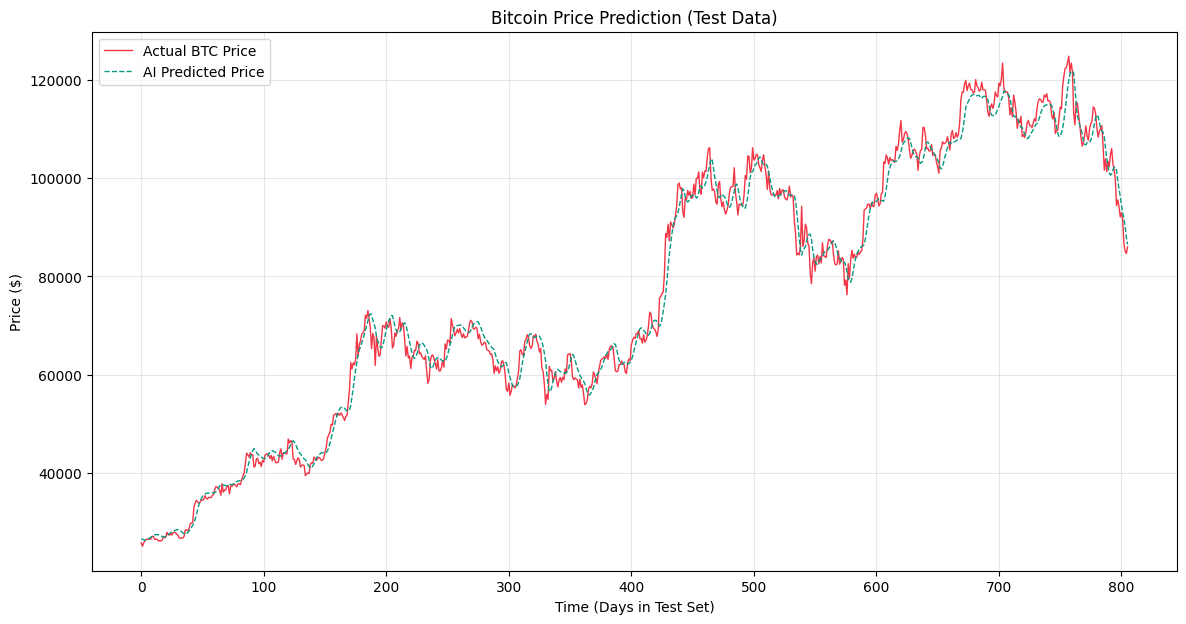

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- CONFIGURATION ---
DATA_FILE = 'C:\\Users\\adith\\Downloads\\TradingProject\\data\\BTC_USD.csv'
MODEL_FILE = 'C:\\Users\\adith\\Downloads\\TradingProject\\models\\market_model.h5'
SCALER_FILE = 'C:\\Users\\adith\\Downloads\\TradingProject\\models\\market_scaler.pkl'
LOOKBACK = 60
TEST_SPLIT = 0.2

print("🚀 Loading Resources...")

# 1. Load Data & Scaler
df = pd.read_csv(DATA_FILE)
scaler = pickle.load(open(SCALER_FILE, "rb"))

# Select Features (Must match training!)
feature_cols = ['BTC_Close', 'BTC_Volume']
dataset = df[feature_cols].values

# Scale Data
scaled_data = scaler.transform(dataset)

# 2. Re-create Sequences (X, y)
X, y = [], []
for i in range(LOOKBACK, len(scaled_data)):
    X.append(scaled_data[i-LOOKBACK:i]) 
    y.append(scaled_data[i, 0]) # Target: BTC Close
    
X, y = np.array(X), np.array(y)

# 3. Split into Test Set (The last 20%)
split_idx = int(len(X) * (1 - TEST_SPLIT))
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"📊 Evaluating on {len(X_test)} unseen data points...")

# 4. Load Model & Predict
model = load_model(MODEL_FILE)
predictions = model.predict(X_test, verbose=0)

# 5. Inverse Scale (Get back to Real $$$)
# We need to create a dummy array because scaler expects 4 columns, but we have 1
dummy_pred = np.zeros((len(predictions), 2))
dummy_test = np.zeros((len(y_test), 2))

dummy_pred[:, 0] = predictions.flatten()
dummy_test[:, 0] = y_test.flatten()

real_predictions = scaler.inverse_transform(dummy_pred)[:, 0]
real_actuals = scaler.inverse_transform(dummy_test)[:, 0]

# 6. Calculate Metrics
rmse = np.sqrt(mean_squared_error(real_actuals, real_predictions))
mae = mean_absolute_error(real_actuals, real_predictions)
mape = np.mean(np.abs((real_actuals - real_predictions) / real_actuals)) * 100
r2 = r2_score(real_actuals, real_predictions)

# 7. Print Report
print("\n" + "="*40)
print("🧪 MODEL PERFORMANCE REPORT")
print("="*40)
print(f"💰 RMSE (Root Mean Sq Error):  ${rmse:,.2f}")
print(f"📉 MAE (Mean Absolute Error): ${mae:,.2f}")
print(f"📊 MAPE (Percentage Error):   {mape:.2f}%")
print(f"📈 R² Score (Accuracy Fit):   {r2:.4f} (Closer to 1.0 is best)")
print("="*40 + "\n")

# 8. Visual Plot
plt.figure(figsize=(14, 7))
plt.plot(real_actuals, color='#f23645', label='Actual BTC Price', linewidth=1)
plt.plot(real_predictions, color='#089981', label='AI Predicted Price', linewidth=1, linestyle='--')
plt.title('Bitcoin Price Prediction (Test Data)')
plt.xlabel('Time (Days in Test Set)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()